In [ ]:
# Find the differnce between fitting the scaler on the training data (as it should be)
# and fitting the scaler on all the data (as it shouldn't be). 

In [19]:
# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Set the plot style
plt.style.use('fivethirtyeight')

In [69]:
df = pd.read_pickle(f"data\\raw_data\\TSLA_raw.pickle")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,93831500,0,0.0
2010-06-30,5.158000,6.084000,4.660000,4.766000,85935500,0,0.0
2010-07-01,5.000000,5.184000,4.054000,4.392000,41094000,0,0.0
2010-07-02,4.600000,4.620000,3.742000,3.840000,25699000,0,0.0
2010-07-06,4.000000,4.000000,3.166000,3.222000,34334500,0,0.0
...,...,...,...,...,...,...,...
2021-02-11,812.440002,829.880005,801.729980,811.659973,21580700,0,0.0
2021-02-12,801.260010,817.330017,785.330017,816.119995,23701700,0,0.0
2021-02-16,818.000000,821.000000,792.440002,796.219971,19686700,0,0.0


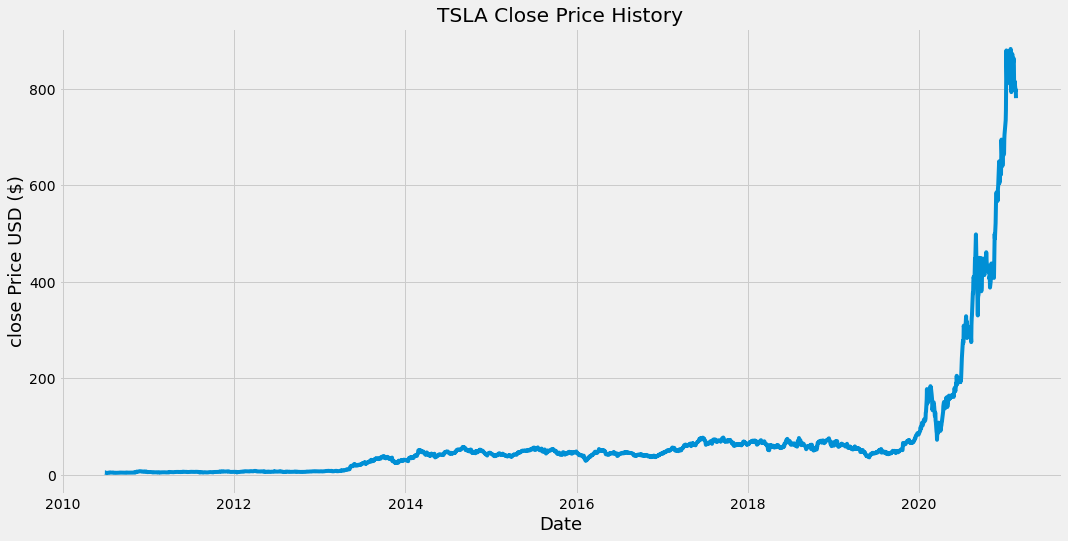

In [70]:
# Vizualoze the closing price history
plt.figure(figsize=(16,8))
plt.title('TSLA Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('close Price USD ($)', fontsize=18)
plt.show()

In [90]:
# Create anew dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
#training_data_len = math.ceil(len(dataset) * 0.8)

#training_data_len
target = df['Close']
target = target.values

In [91]:
X = []
y = target[60:]

for i in range(60, len(dataset)):
    X.append(dataset[i-60:i])

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [95]:
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [96]:
X_train = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2]))

In [98]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [99]:
WINDOW_SIZE = 60
NUM_FEATURES = 1
scaled_train =  np.reshape(scaled_train, (int(scaled_train.shape[0]/WINDOW_SIZE), WINDOW_SIZE, NUM_FEATURES))
scaled_test =  np.reshape(scaled_test, (int(scaled_test.shape[0]/WINDOW_SIZE), WINDOW_SIZE, NUM_FEATURES))

In [100]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(WINDOW_SIZE, NUM_FEATURES)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [101]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [102]:
# Train the model with the training set
model.fit(scaled_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2095/2095 [==============================] - 54s 24ms/step - loss: 586.0042
Epoch 2/10
2095/2095 [==============================] - 51s 24ms/step - loss: 9.7488
Epoch 3/10
2095/2095 [==============================] - 50s 24ms/step - loss: 4.8851
Epoch 4/10
2095/2095 [==============================] - 51s 24ms/step - loss: 3.4868
Epoch 5/10
2095/2095 [==============================] - 51s 24ms/step - loss: 3.1657
Epoch 6/10
2095/2095 [==============================] - 50s 24ms/step - loss: 3.2688
Epoch 7/10
2095/2095 [==============================] - 56s 27ms/step - loss: 3.6289
Epoch 8/10
2095/2095 [==============================] - 52s 25ms/step - loss: 3.1059
Epoch 9/10
2095/2095 [==============================] - 53s 25ms/step - loss: 2.5502
Epoch 10/10
2095/2095 [==============================] - 52s 25ms/step - loss: 2.4844


In [103]:
# Get the model predictions for the the test data
predictions = model.predict(scaled_test)


In [104]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

132.67722113077878

In [105]:
valid = pd.DataFrame(y_test, columns=['Close'])
valid['Predictions'] = predictions

In [106]:
dates = df.index[-len(y_test):]
valid.index = pd.to_datetime(dates)
train = df.filter(['Close'])

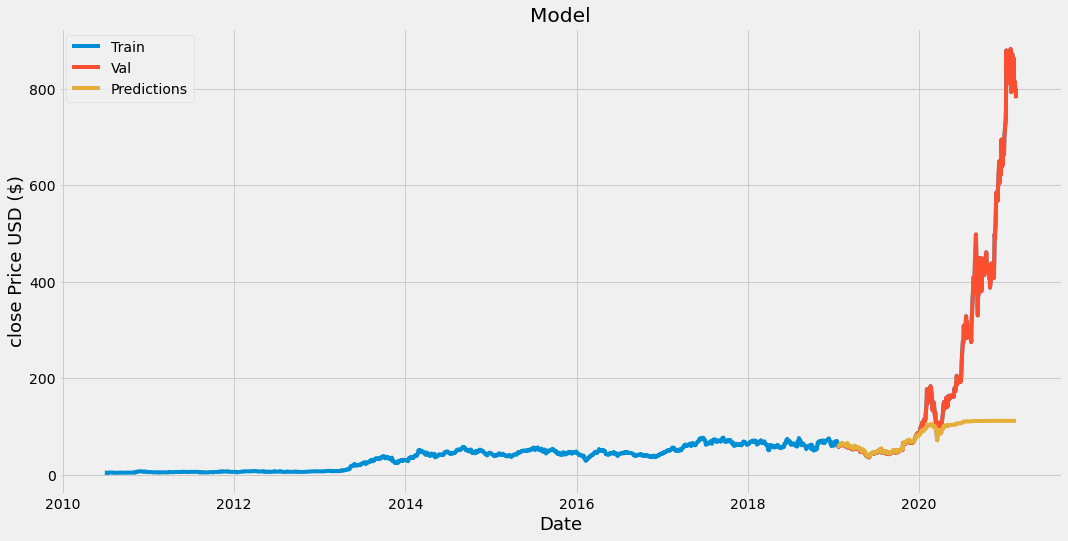

In [107]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('close Price USD ($)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(train)
#plt.plot(valid[['Close', 'Predictions']])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='higer left')
plt.show()

In [73]:
# Scale the data
'''
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data
'''

array([[0.00183878],
       [0.00182514],
       [0.00140011],
       ...,
       [0.90127618],
       [0.90346959],
       [0.88399076]])

In [74]:
'''
train_data = scaled_data[0:training_data_len, :]
train_data
'''

array([[0.00183878],
       [0.00182514],
       [0.00140011],
       ...,
       [0.07205118],
       [0.06689623],
       [0.06467787]])

In [76]:
'''
# Create the scaled training dataset - 80%
train_data = scaled_data[0:training_data_len, :]


# Split the data into x_train and y_train
x_train = []
y_train = []

# Append to x_train arrays of close prices of 60 days
# Append to y_train the close price of the next day (after the 60)
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])
    

    # Print example
    if i <= 61:
        print
        print(x_train)
        print(y_train)
        print()
'''

[array([[1.83878234e-03],
       [1.82514479e-03],
       [1.40011146e-03],
       [7.72788526e-04],
       [7.04599183e-05],
       [0.00000000e+00],
       [3.77302748e-04],
       [3.63665205e-04],
       [2.84113500e-04],
       [5.31860399e-04],
       [9.18254662e-04],
       [9.29619191e-04],
       [1.10008713e-03],
       [1.38874666e-03],
       [1.02280844e-03],
       [1.00462541e-03],
       [1.18191185e-03],
       [1.24782628e-03],
       [1.17054759e-03],
       [1.07963136e-03],
       [1.11827070e-03],
       [1.03417324e-03],
       [9.40983720e-04],
       [1.16372882e-03],
       [1.39783817e-03],
       [1.24100751e-03],
       [1.05690230e-03],
       [8.61432016e-04],
       [8.63705030e-04],
       [7.34149181e-04],
       [4.77310496e-04],
       [4.09123321e-04],
       [5.72772758e-04],
       [6.77326535e-04],
       [7.61423997e-04],
       [6.75053521e-04],
       [6.79599278e-04],
       [7.50059468e-04],
       [9.84169094e-04],
       [7.72788526e-04],

In [77]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2084, 60, 1)

In [78]:
# Reshape the data in order to adjust it to the RNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_train.shape

(2084, 60, 1)

In [79]:
# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [80]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [81]:
# Train the model with the training set
model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2084/2084 [==============================] - 49s 22ms/step - loss: 5.5292e-05
Epoch 2/10
2084/2084 [==============================] - 53s 26ms/step - loss: 1.4173e-05
Epoch 3/10
2084/2084 [==============================] - 50s 24ms/step - loss: 1.3471e-05
Epoch 4/10
2084/2084 [==============================] - 46s 22ms/step - loss: 9.0191e-06
Epoch 5/10
2084/2084 [==============================] - 48s 23ms/step - loss: 6.9628e-06
Epoch 6/10
2084/2084 [==============================] - 55s 26ms/step - loss: 8.1761e-06
Epoch 7/10
2084/2084 [==============================] - 55s 26ms/step - loss: 7.9763e-06
Epoch 8/10
2084/2084 [==============================] - 57s 27ms/step - loss: 5.5456e-06
Epoch 9/10
2084/2084 [==============================] - 57s 27ms/step - loss: 6.1788e-06
Epoch 10/10
2084/2084 [==============================] - 56s 27ms/step - loss: 6.0936e-06


In [84]:
# Create the testing dataset - 20%
test_data = scaled_data[training_data_len-60: , :]

# Split the data into x_train and y_train
# Append to x_train arrays of close prices of 60 days
# Append to y_train the close price of the next day (after the 60)
#x_test = []
#y_test = dataset[training_data_len:, :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
    #x_test.append(test_data[i-60:i, 0])
    x_test.append(test_data[i-60:i])
    y_test.append(test_data[i])

# x_train.append(train_data[i-60:i])
# y_train.append(train_data[i, 1])

In [85]:
# Convert x_test and y_test to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

In [86]:
# Reshape the data in order to adjust it to the RNN
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
x_test.shape

(535, 60, 1)

In [87]:
# Get the model predictions for the the test data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [88]:
# Calculate loss with 'root mean squared error'
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

187.4901529676975

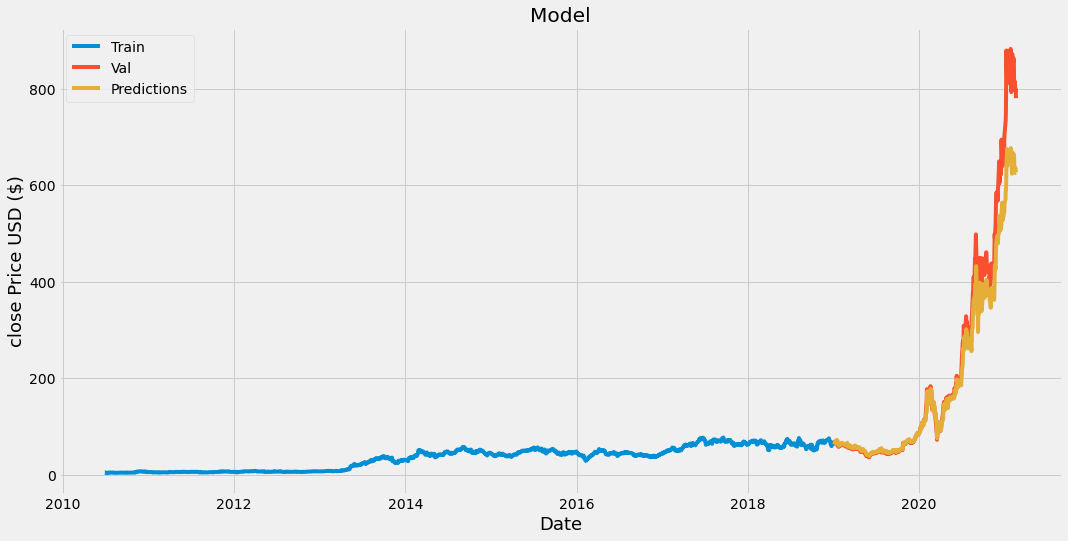

In [89]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Vizualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='higer left')
plt.show()